# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 374545834.30it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111031800.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 130836591.62it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 20202045.35it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


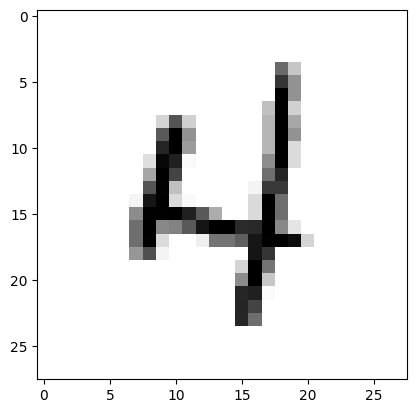

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

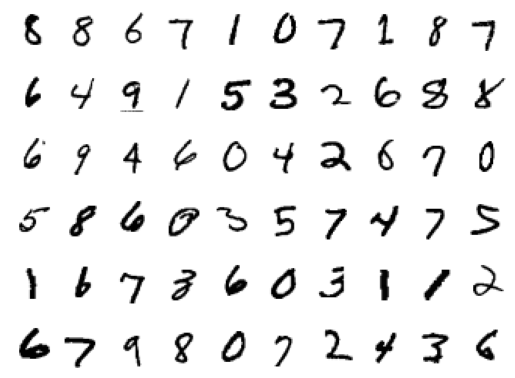

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [ ]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 24

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 8

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 4

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 2

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        x = self.pool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
           Dropout-7           [-1, 16, 24, 24]               0
         MaxPool2d-8           [-1, 16, 12, 12]               0
            Conv2d-9            [-1, 8, 10, 10]           1,152
      BatchNorm2d-10            [-1, 8, 10, 10]              16
             ReLU-11            [-1, 8, 10, 10]               0
           Conv2d-12             [-1, 16, 8, 8]           1,152

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1607733517885208 Batch_id=468 Accuracy=82.75: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]



Test set: Average loss: 0.1745, Accuracy: 9692/10000 (96.92%)

EPOCH: 1


Loss=0.0871206596493721 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]



Test set: Average loss: 0.1680, Accuracy: 9596/10000 (95.96%)

EPOCH: 2


Loss=0.05415469408035278 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]



Test set: Average loss: 0.1492, Accuracy: 9619/10000 (96.19%)

EPOCH: 3


Loss=0.062054723501205444 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]



Test set: Average loss: 0.0797, Accuracy: 9805/10000 (98.05%)

EPOCH: 4


Loss=0.03291427716612816 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]



Test set: Average loss: 0.0699, Accuracy: 9822/10000 (98.22%)

EPOCH: 5


Loss=0.034449007362127304 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:16<00:00, 27.72it/s]



Test set: Average loss: 0.0772, Accuracy: 9804/10000 (98.04%)

EPOCH: 6


Loss=0.01857764832675457 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]



Test set: Average loss: 0.0738, Accuracy: 9801/10000 (98.01%)

EPOCH: 7


Loss=0.008432636968791485 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:18<00:00, 25.95it/s]



Test set: Average loss: 0.0586, Accuracy: 9844/10000 (98.44%)

EPOCH: 8


Loss=0.010236243717372417 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]



Test set: Average loss: 0.0596, Accuracy: 9840/10000 (98.40%)

EPOCH: 9


Loss=0.0323479063808918 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]



Test set: Average loss: 0.0683, Accuracy: 9816/10000 (98.16%)

EPOCH: 10


Loss=0.011781957000494003 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]



Test set: Average loss: 0.0558, Accuracy: 9855/10000 (98.55%)

EPOCH: 11


Loss=0.04573756083846092 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]



Test set: Average loss: 0.0554, Accuracy: 9850/10000 (98.50%)

EPOCH: 12


Loss=0.029329830780625343 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]



Test set: Average loss: 0.0610, Accuracy: 9824/10000 (98.24%)

EPOCH: 13


Loss=0.05875204876065254 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]



Test set: Average loss: 0.0494, Accuracy: 9875/10000 (98.75%)

EPOCH: 14


Loss=0.03518848121166229 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]



Test set: Average loss: 0.0438, Accuracy: 9877/10000 (98.77%)

EPOCH: 15


Loss=0.014832193963229656 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 27.87it/s]



Test set: Average loss: 0.0457, Accuracy: 9867/10000 (98.67%)

EPOCH: 16


Loss=0.050926681607961655 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]



Test set: Average loss: 0.0485, Accuracy: 9858/10000 (98.58%)

EPOCH: 17


Loss=0.053938060998916626 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 27.78it/s]



Test set: Average loss: 0.0474, Accuracy: 9866/10000 (98.66%)

EPOCH: 18


Loss=0.030031459406018257 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]



Test set: Average loss: 0.0494, Accuracy: 9862/10000 (98.62%)

EPOCH: 19


Loss=0.11196958273649216 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]



Test set: Average loss: 0.0459, Accuracy: 9868/10000 (98.68%)



Text(0.5, 1.0, 'Test Accuracy')

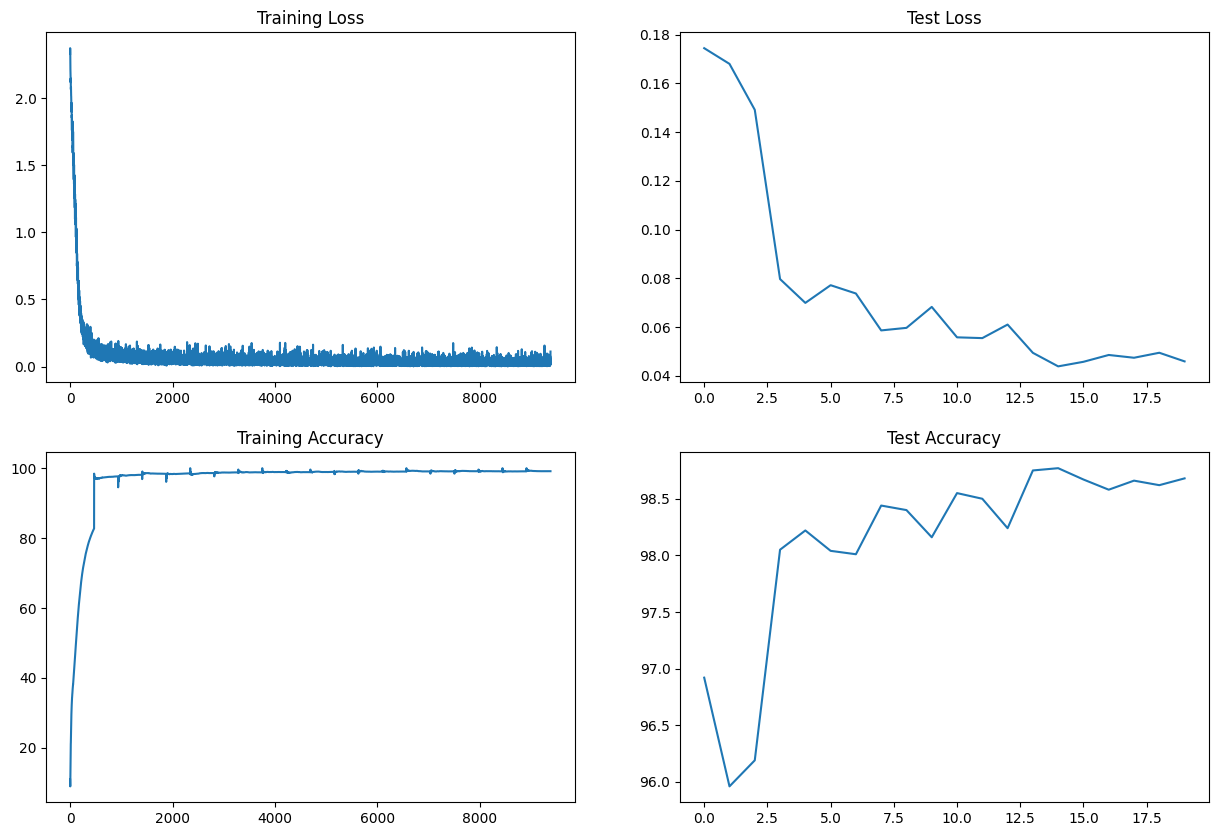

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")